In [47]:
import metnum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, clear_output
from tqdm.notebook import tnrange, tqdm

In [48]:
import numpy as np
from scipy import stats

class KNNClassifier:
    def __init__(self, k):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, Z):
        distances = Z @ self.X_train.T
        norms = np.linalg.norm(Z, axis=1, keepdims=True) * np.linalg.norm(self.X_train, axis=1)
        distances /= norms
        distances = 1 - distances
        sorted_indices = np.argsort(distances, axis=1)[:, :self.k]

        y_pred = stats.mode(self.y_train[sorted_indices], axis=1, keepdims=True)[0].flatten()
        return y_pred
        

In [49]:
X_train = pd.read_csv("./datos/X_train.csv", header=None)[:4000]
y_train = pd.read_csv("./datos/y_train.csv", header=None)[:4000]
X_train=X_train.values
y_train=y_train.values

X_train_dev = pd.read_csv("./datos/X_train.csv", header=None)[4000:5000]
y_train_dev = pd.read_csv("./datos/y_train.csv", header=None)[4000:5000]
X_train_dev=X_train_dev.values
y_train_dev=y_train_dev.values


Ej 3.a

In [50]:
# Realizar un reconocedor de imagenes usando KNN para un k fijo de 5, usando los
# datos de entrenamiento dados y medir la performance con la medida de exactitud
# en el conjunto de prueba.

knn = KNNClassifier(5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train_dev)
accuracy = np.mean(y_pred == y_train_dev)
print(accuracy)

0.812


Ej 3.b

In [51]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from time import time

def knn_K(k, X, y):
    k_fold = StratifiedKFold(n_splits=5)
    k_fold.get_n_splits(X)

    accs, tiempos = ([] for i in range(2))

    #Se va variando la particion con la que se testea del K-Fold
    for train_index, test_index in k_fold.split(X, y):
        # Separamos el conjunto de entrenamiento y el conjunto de test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        cl = KNNClassifier(k)

        time_start = time()

        cl.fit(X_train, y_train)
        y_pred = cl.predict(X_test)

        time_end = time()

        accs.append(accuracy_score(y_test, y_pred))
        tiempos.append(time_end - time_start)

    accs = np.asarray(accs)
    tiempos = np.asarray(tiempos)

    return [accs,
            tiempos]


In [52]:
# TODO: Tomar el promedio de los k?
# Nos da que el mejor k es 1, ¿está bien?

k_list = np.arange(1, 50)

accs = []
tiempos = []
var_tiempo = []

for k in tqdm(k_list):
    ans = knn_K(int(k), X_train, y_train)

    accs.append(ans[0].mean())
    tiempos.append(ans[1].mean())
    var_tiempo.append(ans[1].std())


  0%|          | 0/49 [00:00<?, ?it/s]

In [53]:
print(f'index:{accs.index(max(accs))} max:{max(accs)}')

index:0 max:0.79575


In [54]:
print(f'index:{accs.index(max(accs[1:]))} max:{max(accs[1:])}')

index:3 max:0.7917500000000001


/tmp/ipykernel_1295218/4109801252.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


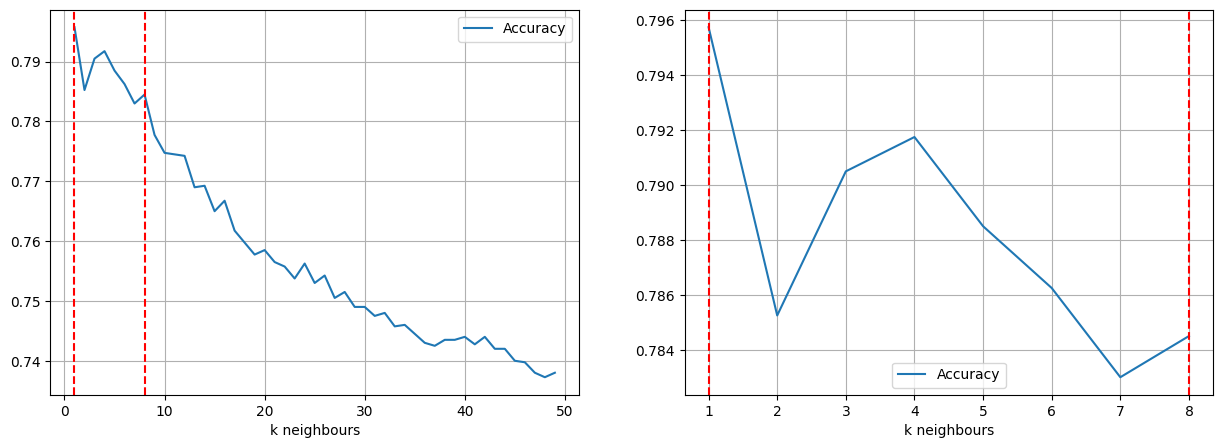

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(k_list, accs)
axs[0].grid()
axs[0].set_xlabel("k neighbours")
axs[0].legend(["Accuracy"])

axs[1].plot(k_list[:8], accs[:8])
axs[1].grid()
axs[1].set_xlabel("k neighbours")
axs[1].legend(["Accuracy"])

axs[0].axvline(x=1, color='r', linestyle='--')
axs[0].axvline(x=8, color='r', linestyle='--')

axs[1].axvline(x=1, color='r', linestyle='--')
axs[1].axvline(x=8, color='r', linestyle='--')

fig.show()
fig.savefig("images/full-con-k.png")

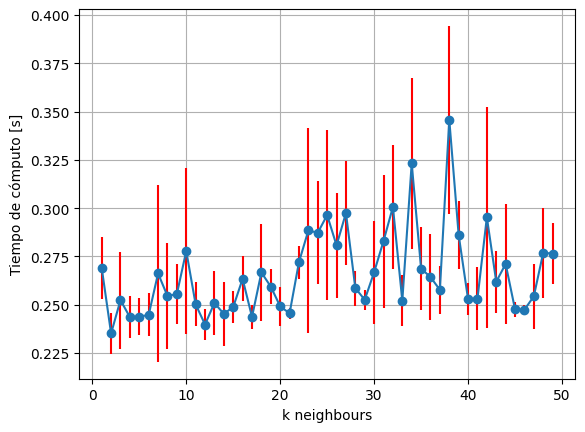

In [56]:
plt.figure("Tiempos con k")
plt.errorbar(k_list, tiempos, yerr=var_tiempo, fmt='-o', ecolor='red')
plt.grid()
plt.xlabel("k neighbours")
plt.ylabel("Tiempo de cómputo [s]")
plt.savefig("images/tiempos-con-k-var.png")
plt.show()

Ej 3.c

Preprocesar los datos de entrenamiento con PCA, usando la implementacion del
metodo de la potencia para encontrar los autovectores de la matriz de covarianza.
Visualizar la cantidad de varianza explicada en funcion de la cantidad de componentes p.

In [57]:
import numpy as np
from sklearn.decomposition import PCA
import metnum
from tqdm.notebook import tnrange, tqdm
k = 15
p_list = np.arange(1, 50)

accs = []
res1 = []
res2 = []


for p in tqdm(p_list):

    pca1 = metnum.PCA(int(p))
    pca1.fit(X_train)
    pca1.transform(X_train)
    res1.append(pca1.get_explained_variance())

    # Probando con la implementación de sklearn
    pca2 = PCA(n_components=int(p))
    pca2.fit(X_train)
    pca2.transform(X_train)
    res2.append(pca2.explained_variance_ratio_)



  0%|          | 0/49 [00:00<?, ?it/s]

KeyboardInterrupt: 

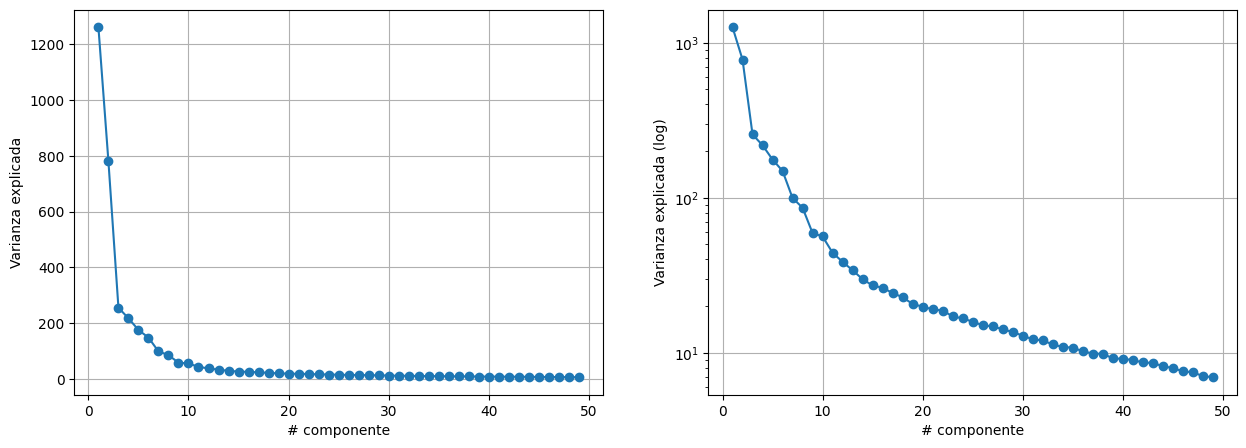

In [91]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(p_list, pca1.get_eigen_values(), '-o')
axs[0].grid()
axs[0].set_xlabel("# componente")
axs[0].set_ylabel("Varianza explicada")

axs[1].semilogy(p_list, pca1.get_eigen_values(), '-o')
axs[1].grid()
axs[1].set_xlabel("# componente")
axs[1].set_ylabel("Varianza explicada (log)")

plt.show()

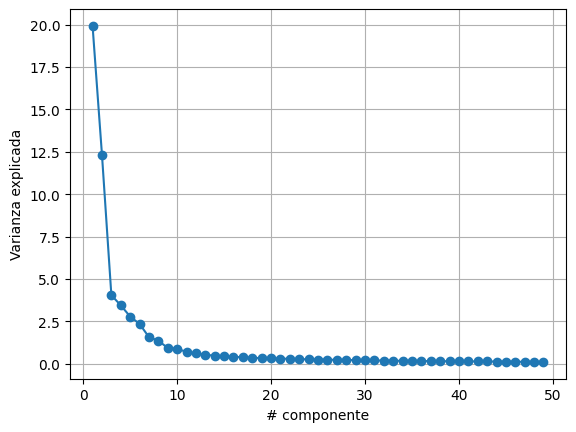

In [49]:
#Graficamos numero de componete vs varianza explicada
plt.plot(p_list, pca2.explained_variance_, '-o')
plt.grid()
plt.xlabel("# componente")
plt.ylabel("Varianza explicada")
plt.show()

# Notamos que parece el mismo grafico pero con diferente escala. PREGUNTAR

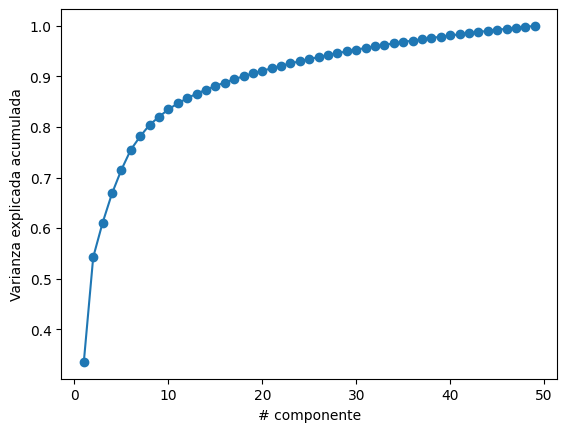

In [56]:
#Graficamos numero de componete vs varianza explicada
plt.plot(p_list, np.cumsum(pca1.get_explained_variance()), '-o')
plt.xlabel("# componente")
plt.ylabel("Varianza explicada acumulada")
plt.show()

# Variando el p de PCA

In [115]:
k = 15
p_list = np.arange(1, 25)

accs = []
tiempos = []


for p in tqdm(p_list):

    time_start = time()

    pca = metnum.PCA(int(p))
    pca.fit(X_train)
    X_trans = pca.transform(X_train)
    time_end = time()
    tiempos.append(time_end- time_start)
    ans = knn_K(k, X_trans, y_train)
    accs.append(ans[0].mean())


  0%|          | 0/24 [00:00<?, ?it/s]

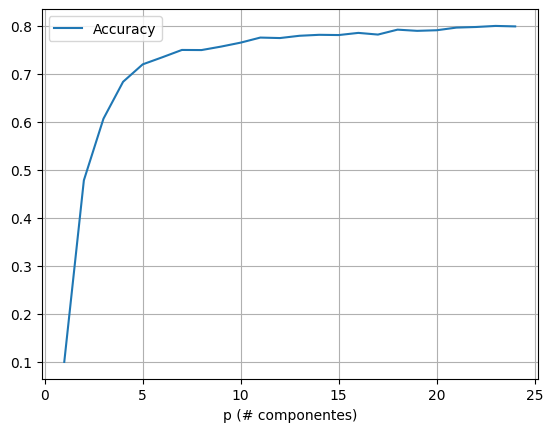

In [119]:
plt.plot(p_list, accs)
plt.grid()
plt.xlabel("p (# componentes)")
plt.ylabel("")
plt.legend(['Accuracy'])
plt.savefig("images/full-con-p.png")
plt.show()

In [79]:
p_list = np.arange(1, 25)

tiempos = []
iteraciones = 30
for alpha in tqdm(p_list):
    tiempos_i = []
    for i in range(iteraciones):
        time_start = time()
        pca = metnum.PCA(int(alpha))
        pca.fit(X_train)
        X_trans = pca.transform(X_train)
        time_end = time()
        tiempos_i.append(time_end- time_start)
    tiempos.append(np.mean(tiempos_i))


  0%|          | 0/24 [00:00<?, ?it/s]

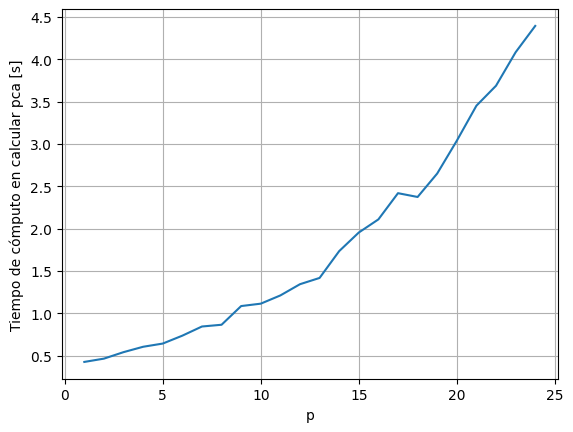

In [80]:
plt.plot(p_list, tiempos)
plt.grid()
plt.xlabel("p")
plt.ylabel("Tiempo de cómputo en calcular pca [s]")
plt.savefig("images/tiempos-con-p.png")
plt.show()

In [21]:
#2.b)
import metnum
import matplotlib.pyplot as plt
import numpy as np

def generar_matriz(autovalores, seed=42):
    np.random.seed(seed)
    # Matriz Diagonal con los autovalores
    D = np.diag(autovalores) 

    v = np.random.rand(D.shape[0], 1)
    # Normalizamos
    v = v / np.linalg.norm(v) 

    # Matriz de Householder
    B = np.eye(D.shape[0]) - 2 * (v @ v.T)

    # Matriz generada
    A = B.T @ D @ B
    return A

In [35]:

epsilon = np.logspace(-4,0,20)
cant_mediciones = 100 # Cantidad de mediciones por cada epsilon
num_iter = 8000 # Cantidad de iteraciones para Metodo de la Potencia
tolerancia = 1e-7
errores_eps = []
convergencia = []
seed = 42
lista_errores_eps = []
lista_convergencia = []

for eps in epsilon:
    autovalores = np.array([10.0, 10.0-eps, 5.0, 2.0, 1.0])
    errores = []
    iteraciones = []
    for i in range(cant_mediciones):
        A = generar_matriz(autovalores, seed + i)
        autoval,autovector,iter = metnum.power_iteration(A,num_iter,tolerancia)
        error = np.linalg.norm(A@autovector - autoval*autovector)
        errores.append(error)
        iteraciones.append(iter)
    # Guardamos el promedio y desvio standard de los errores y la convergencia
    errores_eps.append((np.mean(errores),np.std(errores)))
    convergencia.append((np.mean(iteraciones),np.std(iteraciones)))
    lista_errores_eps.append(errores)
    lista_convergencia.append(iteraciones)
    

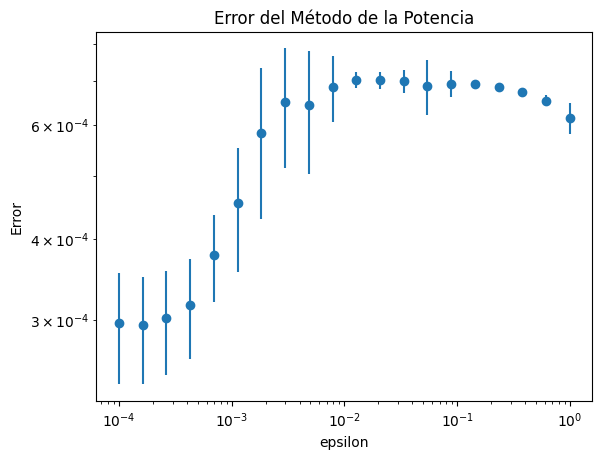

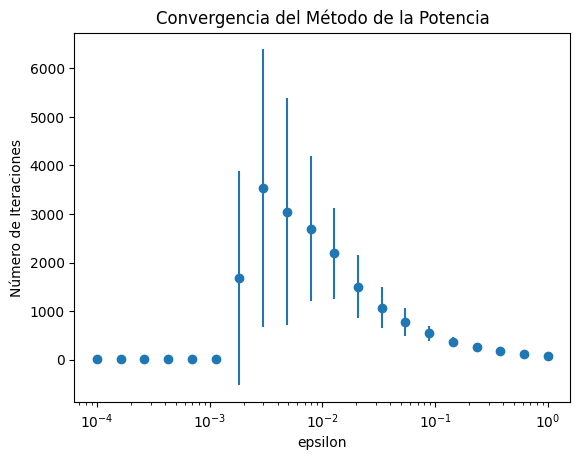

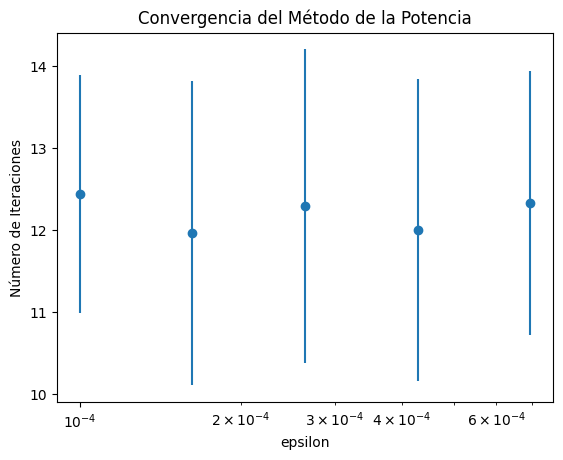

In [36]:
# Graficamos los resultados
mean_errors, std_errors = zip(*errores_eps)
mean_steps, std_steps = zip(*convergencia)

plt.errorbar(epsilon, mean_errors, yerr=std_errors, fmt='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('epsilon')
plt.ylabel('Error')
plt.title('Error del Método de la Potencia')
plt.show()

plt.errorbar(epsilon, mean_steps, yerr=std_steps, fmt='o')
plt.xscale('log')
plt.xlabel('epsilon')
plt.ylabel('Número de Iteraciones')
plt.title('Convergencia del Método de la Potencia')
plt.show()


# Grafico de los primeros 5 epsilon para ver la desviacion estandar
plt.errorbar(epsilon[:5], mean_steps[:5], yerr=std_steps[:5], fmt='o')
plt.xscale('log')
plt.xlabel('epsilon')
plt.ylabel('Número de Iteraciones')
plt.title('Convergencia del Método de la Potencia')
plt.show()

3.d Buscamos mejor "k" y "p"

In [58]:
k_list = np.arange(1, 15)
p_list = np.arange(1, 50)

accs = np.zeros((len(k_list), len(p_list)))

for i, k in enumerate(tqdm(k_list)):
    for j, p in enumerate(p_list):
        pca = metnum.PCA(p)
        pca.fit(X_train)
        accs[i, j] = knn_K(k, pca.transform(X_train), y_train)[0].mean()

best_k_idx, best_p_idx = np.unravel_index(accs.argmax(), accs.shape)

np.save("bests_k_p_15_50.npy", accs)
# 80 min



  0%|          | 0/14 [00:00<?, ?it/s]

In [69]:
best_k_idx, best_p_idx = np.unravel_index(accs.argmax(), accs.shape)
k = k_list[best_k_idx]
p = p_list[best_p_idx]
print(f"Mejor k: {k}, mejor p: {p}")


Mejor k: 4, mejor p: 45


In [66]:
accs[best_k_idx, best_p_idx]

0.817

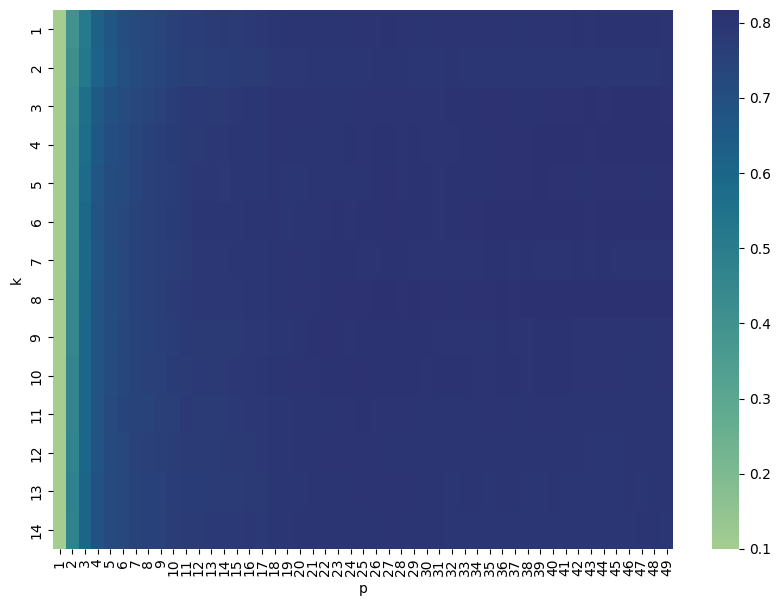

<Figure size 640x480 with 0 Axes>

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(accs, fmt=".3f", xticklabels=p_list, yticklabels=k_list, ax=ax, cmap="crest")
ax.set_xlabel("p")
ax.set_ylabel("k")
plt.show()
plt.savefig("images/heatmap_p_k.png")

# Parte final: Vamos con los datos de test

In [72]:
X_test = pd.read_csv("./datos/X_test.csv", header=None)
y_test = pd.read_csv("./datos/y_test.csv", header=None)

In [77]:
knn = KNNClassifier(k)
pca = metnum.PCA(p)
pca.fit(X_train)
knn.fit(pca.transform(X_train), y_train)

y_pred = knn.predict(pca.transform(X_test))
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.832
